Казакова А.С.
Данная версия является обновлением тестового задания из ОК с учетом фидбека

In [366]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [367]:
# Считывание данных
artist_data = pd.read_csv('/content/lastfm_artist_list.csv', index_col =0)
artist_data.head()

,artist_name
artist_id,
1,__Max__
2,_Algol_
3,-123 Min.
4,-Oz-
5,-T De Sangre


In [368]:
# Посмотрим на данные (их тип и количество nan)
artist_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17493 entries, 1 to 17493
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist_name  17493 non-null  object
dtypes: object(1)
memory usage: 273.3+ KB


In [369]:
# Считывание данных о прослушивании
scrobbles_data =pd.read_csv('/content/lastfm_user_scrobbles.csv')
scrobbles_data.head()

,user_id,artist_id,scrobbles
0,1,4562,13883
1,1,10191,11690
2,1,494,11351
3,1,6673,10300
4,1,8402,8983


In [370]:
# Посмотрим на данные (их тип и количество nan)
scrobbles_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92792 entries, 0 to 92791
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    92792 non-null  int64
 1   artist_id  92792 non-null  int64
 2   scrobbles  92792 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB


В наших данных нет пропущенных значений.
Как я поняла значение scrobbles показывает кого слушал пользователь. То есть если scrobbles высокий это означает, что пользователь много слушал данного артиста, а значит он ему нравится (возможно это количество включенных песен, возможно время прослушивания, не совсем поняла, но точно логика такая)

In [371]:
# Выведем основные характеристики 
scrobbles_data.describe()

,user_id,artist_id,scrobbles
count,92792.000000,92792.000000,92792.000000
mean,945.175845,8440.215687,745.521521
std,546.755311,4879.112200,3752.146187
min,1.000000,1.000000,1.000000
25%,471.000000,4037.000000,107.000000
50%,945.000000,8460.000000,260.000000
75%,1417.000000,12435.000000,614.000000
max,1892.000000,17493.000000,352698.000000


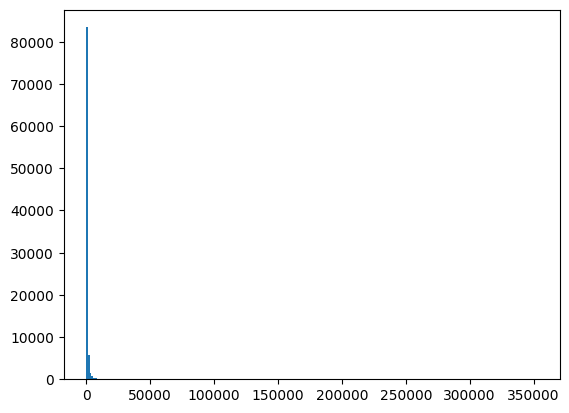

In [372]:
plt.hist(scrobbles_data['scrobbles'], bins = 256)
plt.show()

In [373]:
# выведем число уникальных пользователей, артистов
# и количество уникальных scrobbles
print('Количество уникальных пользователей:', scrobbles_data['user_id'].nunique())
print('Количество уникальных артистов:', artist_data['artist_name'].nunique())
print('Количество уникальных scrobbles:', scrobbles_data['scrobbles'].nunique())

Количество уникальных пользователей: 1892
Количество уникальных артистов: 17492
Количество уникальных scrobbles: 5436


Можно заметить очень сильный разброс данных с 75% до максимума. По гистограмме видно распределение scrobbles. Чаще всего в задачах рекомендационных систем распределение имеет именно такой вид. Это обуславливается тем, что в среднем люди слушают музыку не так много, но есть люди, которые слушают музыку (особенно любимого исполнителя) очень много и из-за этого становятся некими выбросами в выборке.

Также в наших данных содержатся фиты исполнителей. Причем разделители у них разные. Что делать с такими данными? Искать всевозможные разделители в большом объеме данных долго (даже в случае чего вдруг фит обозначается символом & и по идее с помощью регулярных выражений можно было бы достать обоих (или больше) исполнителей, но что если у нас есть группа, название которой имеет ту же схему "кто-то & кто-то", как разграничивать эти ситуации?). И даже если мы разделим их, то что потом делать с значением scrobbles? Прибавлять к каждому артисту или прибавлять половину от него? Также есть будто недописанные артисты. Например: britney и britney spears. Как понять, это один и тот же артист или разные? Скорее всего данные вопросы решаются data analyst. А если нет, то я считаю, что необходимо посоветоваться с командой и решить что будет правильнее/выгоднее

In [374]:
# Объединим обе таблицы
join_data = scrobbles_data.join(artist_data, how ='left', on='artist_id')
join_data.head()

,user_id,artist_id,scrobbles,artist_name
0,1,4562,13883,Duran Duran
1,1,10191,11690,Morcheeba
2,1,494,11351,Air
3,1,6673,10300,Hooverphonic
4,1,8402,8983,Kylie Minogue


In [375]:
# На всякий случай проверяем правильно ли все соединилось
artist_data.loc[[4562,10191,494,6673,8402]]

,artist_name
artist_id,
4562,Duran Duran
10191,Morcheeba
494,Air
6673,Hooverphonic
8402,Kylie Minogue


In [376]:
join_data.to_parquet('/content/join_data.parquet')

In [377]:
# Создадим "кросс-таблицу", где столбцы это музыкальные исполнители, а
# строчки - id пользователей. На пересечении будет стоять
# значение scrobbles
cross_tab = join_data.pivot_table(index = 'user_id', columns = 'artist_name', values = 'scrobbles', aggfunc='sum')
cross_tab.head()

artist_name,!!!,!Deladap,!Distain,#####,#2 Orchestra,$Lick,$Lick Feat. Six-Fo,(1962-1966),(Hed) Planet Earth,(Pre) Kingdom,...,티아라,현아,Ｂｏｏｇｉｅｍａｎ,Ｂｏｒｎ,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,Ｍａｃｈｉｎｅ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [378]:
# На всякий случай перепроверяем показания первых пяти столбцов 
# прошлой таблицы
cross_tab[['Duran Duran','Morcheeba','Air','Hooverphonic','Kylie Minogue']]

artist_name,Duran Duran,Morcheeba,Air,Hooverphonic,Kylie Minogue
user_id,,,,,
1,13883.0,11690.0,11351.0,10300.0,8983.0
2,NaN,NaN,NaN,NaN,NaN
3,228.0,NaN,686.0,NaN,NaN
4,NaN,NaN,181.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1888,NaN,NaN,NaN,NaN,NaN
1889,NaN,NaN,NaN,NaN,NaN
1890,NaN,NaN,NaN,NaN,NaN


In [379]:
# Также проверим ненулевые значения
print('Ненулевых значений в новой таблице:', cross_tab.shape[0]*cross_tab.shape[1]-cross_tab.isnull().sum().sum())
print('Не хватает', scrobbles_data.shape[0]-(cross_tab.shape[0]*cross_tab.shape[1]-cross_tab.isnull().sum().sum()), 'записей')

Ненулевых значений в новой таблице: 92723
Не хватает 69 записей


Нехватка записей обусловлена тем, что существуют строчки в датафрейме scrobbles_data, которые полностью повторяются, но значения scrobbles у них разные. При создании кросс-таблицы они складываются, поэтому значений меньше. 

In [380]:
# Проверим сколько записей, содержащих повтор
scrobbles_data[scrobbles_data.duplicated(['user_id','artist_id'])]

,user_id,artist_id,scrobbles
3202,65,857,63
8509,172,17063,28
8512,172,17110,17
9072,185,10311,964
10487,213,7314,126
...,...,...,...
83279,1700,472,138
84429,1724,11592,717
89391,1823,16174,138
89438,1824,8777,22


Как можно заметить, их как раз 69. Следовательно, данные не потерялись

In [381]:
# Для применения функции близости необходимо вычесть среднее  
normalise_data = cross_tab.subtract(cross_tab.mean(axis=1), axis = 0) 
normalise_data.head()

artist_name,!!!,!Deladap,!Distain,#####,#2 Orchestra,$Lick,$Lick Feat. Six-Fo,(1962-1966),(Hed) Planet Earth,(Pre) Kingdom,...,티아라,현아,Ｂｏｏｇｉｅｍａｎ,Ｂｏｒｎ,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,Ｍａｃｈｉｎｅ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [382]:
# Для сохранения данных в формате parquet
# переведем названия столбцов в строковый тип
normalise_data.index = normalise_data.index.astype(str)

In [383]:
# Скачивание данных
normalise_data.to_parquet('/content/normalise_data.parquet')

In [384]:
# Cчитывание данных на случай нехватки памяти
#normalise_data = pd.read_parquet('/content/normalise_data.parquet')
#normalise_data.head()

# Корреляция Пирсона


In [385]:
# Подсчет корреляции Пирсона
pearson_corr_data = normalise_data.T.corr() 
pearson_corr_data.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,-0.272796,NaN,NaN,-0.547734,-0.581934,NaN,NaN,-1.0,...,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,-0.421803,NaN,NaN
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.272796,NaN,1.000000,0.216518,NaN,NaN,NaN,NaN,-1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.157205,0.999678,NaN,NaN
4,NaN,NaN,0.216518,1.000000,NaN,NaN,NaN,NaN,-0.116231,-1.0,...,1.0,NaN,-0.002731,NaN,NaN,NaN,0.357368,0.122159,NaN,NaN
5,NaN,NaN,NaN,NaN,1.0,NaN,-0.987467,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [386]:
# Проверка размерности 
pearson_corr_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1892 entries, 1 to 1892
Columns: 1892 entries, 1 to 1892
dtypes: float64(1892)
memory usage: 27.4+ MB


In [387]:
# Сохранение в отдельный файл
pearson_corr_data.to_parquet('/content/pearson_corr_data.parquet')

In [388]:
# Считываение из файла
#pearson_corr_data = pd.read_parquet('/content/pearson_corr_data.parquet')
#pearson_corr_data.head()

In [389]:
# Далее приводится алгоритм рекомендации для Ac/Dc
# Находим наибольшее значение scrobbles
max_scrob = join_data[join_data['artist_name']=='Ac/Dc']['scrobbles'].max()

In [390]:
# Находим id пользователя, который больше всего слушал данного исполнителя
user_id =join_data[(join_data['scrobbles'] ==max_scrob) & (join_data['artist_name']=='Ac/Dc')]['user_id'].values
user_id = user_id.astype('str')
user_id

array(['376'], dtype='<U21')

In [391]:
# Из таблицы схожести пользователей убираем строку нашего пользователя 
# и оставляем столбец для поиска походих пользователей
new_data = pearson_corr_data
new_data.drop(index=user_id, inplace=True)
user_corr = new_data[user_id]
user_corr

user_id,376
user_id,
1,NaN
2,NaN
3,NaN
4,-0.306055
5,NaN
...,...
1888,NaN
1889,-0.065749
1890,0.376577


In [392]:
# Найдем n похожих пользователей
n_similar_user = 10
similar_users = user_corr.sort_values(by = user_corr.columns[0], ascending=False)[:n_similar_user]
similar_users

user_id,376
user_id,
438,1.0
833,1.0
890,1.0
1184,1.0
1132,1.0
1112,1.0
156,1.0
1362,1.0
882,1.0


In [393]:
# Удалим всех исполнителей, которых не слушал наш пользователь
user_id_listen_artists = normalise_data.loc[user_id].dropna(axis=1, how='all')
user_id_listen_artists

artist_name,Ac/Dc,Aerosmith,Alice Cooper,Anthrax,Black Sabbath,Bob Dylan,Bon Jovi,Cannibal Corpse,Death,Deep Purple,...,Slayer,T. Rex,Tenacious D,The Beatles,The Clash,The Doors,The Rolling Stones,The Who,U2,Van Halen
user_id,,,,,,,,,,,,,,,,,,,,,
376,2767.86,677.86,-741.14,-1573.14,490.86,-763.14,-1542.14,-1692.14,-751.14,-1560.14,...,-231.14,-1657.14,-1322.14,2596.86,-959.14,10846.86,-1329.14,-77.14,-1562.14,-1285.14


In [394]:
# Аналогично у наших похожих пользователей удалим исполнителей, которых они не слушали 
users_listen_artists = normalise_data[normalise_data.index.isin(similar_users.index)].dropna(axis=1, how='all')
users_listen_artists

artist_name,*Nsync,3 Na Massa,A Day To Remember,A Silver Mt. Zion,A-Ha,Aaron Carter,Abba,Ac/Dc,Adam Lambert,Adele,...,Within Temptation,Wolfchant,Wolfgang Amadeus Mozart,Wolfsheim,Xtc,Yann Tiersen,Yeah Yeah Yeahs,Yiruma,Zbigniew Preisner,Zero 7
user_id,,,,,,,,,,,,,,,,,,,,,
156,-84.74,NaN,NaN,NaN,NaN,-78.74,NaN,NaN,116.26,NaN,...,NaN,NaN,NaN,NaN,NaN,-165.74,NaN,NaN,NaN,NaN
438,NaN,NaN,NaN,NaN,NaN,NaN,-491.56,NaN,NaN,NaN,...,NaN,NaN,-405.56,NaN,-463.56,NaN,NaN,-265.56,-278.56,NaN
833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-4182.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,NaN,NaN,NaN,NaN,-124.92,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,167.08,NaN,55.08,NaN,NaN,NaN,NaN
890,NaN,-93.632653,121.367347,NaN,NaN,NaN,NaN,260.367347,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1112,NaN,NaN,NaN,NaN,-227.38,NaN,NaN,NaN,NaN,-452.38,...,NaN,NaN,NaN,NaN,NaN,NaN,-358.38,NaN,NaN,NaN
1132,NaN,NaN,NaN,115.62,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-82.38,NaN,NaN,NaN
1184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1362,NaN,NaN,NaN,NaN,-751.18,NaN,NaN,NaN,NaN,NaN,...,1578.82,NaN,NaN,-687.18,NaN,NaN,NaN,NaN,NaN,NaN


In [395]:
# Теперь уберем пересечения нашего пользователя и похожих пользователей
# ведь мы хотим рекомендовать нового артиста
users_listen_artists.drop(user_id_listen_artists.columns,axis=1, inplace=True, errors='ignore')
users_listen_artists

artist_name,*Nsync,3 Na Massa,A Day To Remember,A Silver Mt. Zion,A-Ha,Aaron Carter,Abba,Adam Lambert,Adele,Adiemus,...,Within Temptation,Wolfchant,Wolfgang Amadeus Mozart,Wolfsheim,Xtc,Yann Tiersen,Yeah Yeah Yeahs,Yiruma,Zbigniew Preisner,Zero 7
user_id,,,,,,,,,,,,,,,,,,,,,
156,-84.74,NaN,NaN,NaN,NaN,-78.74,NaN,116.26,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-165.74,NaN,NaN,NaN,NaN
438,NaN,NaN,NaN,NaN,NaN,NaN,-491.56,NaN,NaN,-474.56,...,NaN,NaN,-405.56,NaN,-463.56,NaN,NaN,-265.56,-278.56,NaN
833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-4182.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
882,NaN,NaN,NaN,NaN,-124.92,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,167.08,NaN,55.08,NaN,NaN,NaN,NaN
890,NaN,-93.632653,121.367347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1112,NaN,NaN,NaN,NaN,-227.38,NaN,NaN,NaN,-452.38,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-358.38,NaN,NaN,NaN
1132,NaN,NaN,NaN,115.62,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-82.38,NaN,NaN,NaN
1184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1362,NaN,NaN,NaN,NaN,-751.18,NaN,NaN,NaN,NaN,NaN,...,1578.82,NaN,NaN,-687.18,NaN,NaN,NaN,NaN,NaN,NaN


In [396]:
# Посчитаем оценку исполнителя, а затем отсортируем по ней
# Будем использовать средневзвешенное значение
item_score = {}
for i in users_listen_artists.columns:
  rating = users_listen_artists[i]
  total = 0
  count = 0
  for u in similar_users.index:
    if pd.isna(rating[u]) == False:
      score = similar_users.loc[u].values * rating[u]
      total += score
      count +=1
  item_score[i] = total / count
item_score = pd.DataFrame(item_score.items(), columns=['artist', 'scrobble_score'])
ranked_item_score = item_score.sort_values(by='scrobble_score', ascending=False)
ranked_item_score

,artist,scrobble_score
159,In Flames,[141300.34000000003]
21,Amon Amarth,[9142.340000000002]
99,Depeche Mode,[7165.95]
252,Norah Jones,[5299.440000000003]
41,Backstreet Boys,[4243.26]
...,...,...
228,Misfits,[-4445.660000000001]
24,Anberlin,[-4486.660000000001]
266,Papa Roach,[-4498.660000000001]
100,Dethklok,[-4515.660000000001]


In [397]:
# Вывод похожих пользователей
list(ranked_item_score['artist'].iloc[0:5].values)

['In Flames', 'Amon Amarth', 'Depeche Mode', 'Norah Jones', 'Backstreet Boys']

# Косинусная мера близости

In [398]:
#  Подсчет косинусной меры близости
cosine_data = pd.DataFrame(cosine_similarity(normalise_data.fillna(0)), index= normalise_data.index,columns = normalise_data.index)
cosine_data.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.0,-0.051503,-0.024420,0.004619,-0.003687,0.00583,0.0,0.000000,-0.035405,...,0.000000,-0.021837,0.000000,0.004578,0.004031,0.0,0.005467,-0.039318,0.000000,0.0
2,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.002499,0.0
3,-0.051503,0.0,1.000000,-0.000397,0.002180,0.000000,0.00000,0.0,-0.009745,0.000911,...,0.000000,0.000000,-0.000974,-0.000943,0.000000,0.0,-0.013860,0.785065,0.000000,0.0
4,-0.024420,0.0,-0.000397,1.000000,0.000000,0.000000,0.00000,0.0,-0.011661,0.015911,...,0.019673,0.000000,0.010881,0.000000,0.000000,0.0,0.101477,0.020734,0.000000,0.0
5,0.004619,0.0,0.002180,0.000000,1.000000,-0.002252,-0.00230,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [399]:
# Сохранение в отдельный файл
cosine_data.to_parquet('/content/cosine_data.parquet')

In [400]:
# Из таблицы схожести пользователей убираем строку нашего пользователя 
# и оставляем столбец для поиска походих пользователей
cosine_data.drop(index=user_id, inplace=True)
user_corr = cosine_data[user_id]
user_corr

user_id,376
user_id,
1,0.000000
2,0.000000
3,-0.004090
4,-0.005171
5,0.000000
...,...
1888,0.000000
1889,-0.005800
1890,0.009029


In [401]:
# Найдем n похожих пользователей
n = 10
similar_users = user_corr.sort_values(by = user_corr.columns[0], ascending=False)[:n]
similar_users

user_id,376
user_id,
110,0.564329
1305,0.523783
458,0.492540
1150,0.478230
824,0.449571
827,0.439790
1469,0.406047
1667,0.395298
105,0.378562


In [402]:
# Удалим всех исполнителей, которых не слушал наш пользователь
user_id_listen_artists = normalise_data.loc[user_id].dropna(axis=1, how='all')
user_id_listen_artists

artist_name,Ac/Dc,Aerosmith,Alice Cooper,Anthrax,Black Sabbath,Bob Dylan,Bon Jovi,Cannibal Corpse,Death,Deep Purple,...,Slayer,T. Rex,Tenacious D,The Beatles,The Clash,The Doors,The Rolling Stones,The Who,U2,Van Halen
user_id,,,,,,,,,,,,,,,,,,,,,
376,2767.86,677.86,-741.14,-1573.14,490.86,-763.14,-1542.14,-1692.14,-751.14,-1560.14,...,-231.14,-1657.14,-1322.14,2596.86,-959.14,10846.86,-1329.14,-77.14,-1562.14,-1285.14


In [403]:
# Аналогично у наших похожих пользователей удалим исполнителей, которых они не слушали 
users_listen_artists = normalise_data[normalise_data.index.isin(similar_users.index)].dropna(axis=1, how='all')
users_listen_artists

artist_name,3 Doors Down,Abba,Ac/Dc,Aereogramme,Aerosmith,Air Supply,Alice Cooper,Alice In Chains,Alter Bridge,America,...,Wham!,White Lies,Whitesnake,Włochaty,Yazoo,Zespoł Reprezentacyjny,Zz Top,Łąki Łan,増田俊郎,菅野よう子
user_id,,,,,,,,,,,,,,,,,,,,,
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-300.56,NaN,NaN,...,NaN,-322.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,1174.64,NaN,363.64,NaN,-287.36,NaN,...,NaN,NaN,-189.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,850.54,NaN,4.54,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,-1018.48,NaN,-963.48,NaN,NaN,NaN,NaN,NaN,NaN,-1020.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
824,NaN,NaN,-37.04,NaN,-85.04,NaN,-66.04,NaN,NaN,NaN,...,NaN,NaN,-48.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-154.76,-235.76,-236.76,-207.76,587.24
1150,NaN,NaN,-75.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1305,NaN,NaN,-11.94,NaN,NaN,10.06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1469,NaN,-1469.66,-294.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1431.66,NaN,NaN,NaN,NaN,NaN,NaN


In [404]:
# Теперь уберем пересечения нашего пользователя и похожих пользователей
# ведь мы хотим рекомендовать нового артиста
users_listen_artists.drop(user_id_listen_artists.columns,axis=1, inplace=True, errors='ignore')
users_listen_artists

artist_name,3 Doors Down,Abba,Aereogramme,Air Supply,Alice In Chains,Alter Bridge,America,Angra,Apocalyptica,Arctic Monkeys,...,Wham!,White Lies,Whitesnake,Włochaty,Yazoo,Zespoł Reprezentacyjny,Zz Top,Łąki Łan,増田俊郎,菅野よう子
user_id,,,,,,,,,,,,,,,,,,,,,
67,NaN,NaN,NaN,NaN,-300.56,NaN,NaN,NaN,NaN,-72.56,...,NaN,-322.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,NaN,-287.36,NaN,NaN,NaN,NaN,...,NaN,NaN,-189.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,-1018.48,NaN,NaN,NaN,NaN,NaN,-1020.48,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-48.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-93.76,NaN,...,NaN,NaN,NaN,NaN,NaN,-154.76,-235.76,-236.76,-207.76,587.24
1150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-525.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1305,NaN,NaN,NaN,10.06,NaN,NaN,NaN,-7.94,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1469,NaN,-1469.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1431.66,NaN,NaN,NaN,NaN,NaN,NaN


In [405]:
# Посчитаем оценку исполнителя, а затем отсортируем по ней
item_score = {}
for i in users_listen_artists.columns:
  rating = users_listen_artists[i]
  total = 0
  count = 0
  for u in similar_users.index:
    if pd.isna(rating[u]) == False:
      score = similar_users.loc[u].values * rating[u]
      total += score
      count +=1
  item_score[i] = total / count
item_score = pd.DataFrame(item_score.items(), columns=['artist', 'scrobble_score'])
ranked_item_score = item_score.sort_values(by='scrobble_score', ascending=False)
ranked_item_score

,artist,scrobble_score
53,David Bowie,[723.5807223507732]
61,Duran Duran,[718.8966096533684]
177,Rory Gallagher,[614.0806807216712]
209,The Hives,[284.4163187588337]
146,O.S.T.R.,[263.9798410052072]
...,...,...
145,Nuclear Assault,[-617.0529426355813]
176,Roger Waters,[-619.4892228928845]
132,Misfits,[-628.4222505029965]
196,Stare Dobre Małżeństwo,[-631.6706241794009]


In [406]:
# Вывод похожих пользователей
list(ranked_item_score['artist'].iloc[0:5].values)

['David Bowie', 'Duran Duran', 'Rory Gallagher', 'The Hives', 'O.S.T.R.']

In [407]:
# Считываение из файла
#cosine_data = pd.read_parquet(('/content/cosine_data.parquet')
#cosine_data.head()

С метриками расстояний knn можно поиграться, но поскольку в литературе в основном говорится о корреляции Пирсона и косинусной мере близости, я решила оставить только их. При metric='correlation' расстояния и индексы ближайших соседей считались значительно дольше

# Реализация с Knn


In [408]:
# Попробуем использовать ближайших соседей с косинусной метрикой расстояния 
knn_cosine = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
knn_cosine.fit(normalise_data.fillna(0).values)
distances_cosine, indices_cosine = knn_cosine.kneighbors(normalise_data.fillna(0).values, n_neighbors=10)

In [409]:
# Поскольку индексы хранятся от 0, сдвинем их
indices_cosine += 1
indices_cosine

array([[   1, 1687,  401, ..., 1432,  539, 1699],
       [   2, 1569,   58, ...,  755,  851, 1891],
       [   3, 1483, 1875, ...,  417, 1006,  120],
       ...,
       [1890, 1483, 1875, ...,   60,  417,   99],
       [1891,  971,  783, ...,  239,  160,  101],
       [1892,  549,   31, ..., 1426, 1780,  607]])

In [410]:
# Создадим массив пар вида (индексы, расстояние)
tuple_array_cosine = tuple(zip(indices_cosine,distances_cosine))

In [411]:
# Обернем данные в датафрейм чтобы в дальнейшем сохранить его
knn_cosine_data = pd.DataFrame(tuple_array_cosine,index = range(1,1893), columns = ['indices', 'distances'])
knn_cosine_data.index = knn_cosine_data.index.astype('str')
knn_cosine_data

,indices,distances
1,"[1, 1687, 401, 1104, 1103, 352, 1484, 1432, 53...","[4.440892098500626e-16, 0.49817492532974117, 0..."
2,"[2, 1569, 58, 344, 1172, 399, 418, 755, 851, 1...","[2.220446049250313e-16, 0.9788753290053891, 0...."
3,"[3, 1483, 1875, 29, 99, 715, 529, 417, 1006, 120]","[3.3306690738754696e-16, 0.11154599126615938, ..."
4,"[4, 259, 848, 530, 1277, 162, 1610, 843, 1023,...","[1.1102230246251565e-16, 0.43785360162710607, ..."
5,"[5, 1533, 1372, 845, 583, 764, 1171, 133, 679,...","[3.3306690738754696e-16, 0.8755142128752939, 0..."
...,...,...
1888,"[1888, 1780, 59, 31, 1157, 1426, 607, 1333, 18...","[1.1102230246251565e-16, 0.8302933867064526, 0..."
1889,"[1889, 797, 1279, 1269, 1301, 721, 763, 663, 4...","[2.220446049250313e-16, 0.18424462682705145, 0..."
1890,"[1890, 1483, 1875, 29, 529, 715, 120, 60, 417,...","[0.0, 0.13728184355062223, 0.14033861521971125..."
1891,"[1891, 971, 783, 66, 1694, 778, 1263, 239, 160...","[0.0, 0.7676008543651233, 0.8523195188309663, ..."


In [412]:
# Сохраняем данные
knn_cosine_data.to_parquet('/content/indices_cosine.parquet')

In [413]:
# Находим пользователя, который больше всего слушал Ac/Dc
max_scrob = join_data[join_data['artist_name']=='Ac/Dc']['scrobbles'].max()
user_id =join_data[(join_data['scrobbles'] ==max_scrob) & (join_data['artist_name']=='Ac/Dc')]['user_id'].values.astype('str')
# Записываем индексы и расстояние похожих на него пользователей
similar_users = knn_cosine_data['indices'].loc[user_id].tolist()
similar_users = [str(x) for x in similar_users[0]]
distance_similar_users = knn_cosine_data['distances'].loc[user_id].tolist()
distance_similar_users = [str(x) for x in distance_similar_users[0]]
# Убираем его самого
similar_users.remove(user_id)
distance_similar_users.remove(distance_similar_users[0])
print('KNN cosine recommends:', normalise_data.loc[similar_users].index.tolist())

KNN cosine recommends: ['110', '1305', '458', '1150', '824', '827', '1469', '1667', '105']


In [414]:
# Создадим датафрейм с похожими пользователями 
data_distance = pd.DataFrame(data = distance_similar_users, index= similar_users)
data_distance

,0
110,0.43567076968950325
1305,0.47621716735662034
458,0.5074596417519549
1150,0.5217700350777525
824,0.5504289940082057
827,0.5602100879157937
1469,0.593953290449455
1667,0.6047021314769614
105,0.6214375763773583


In [415]:
# Удалим всех исполнителей, которых не слушал наш пользователь
user_id_listen_artists = normalise_data.loc[user_id].dropna(axis=1, how='all')
# Аналогично у наших похожих пользователей удалим исполнителей, которых они не слушали 
users_listen_artists = normalise_data[normalise_data.index.isin(similar_users)].dropna(axis=1, how='all')
users_listen_artists.head()
users_listen_artists.drop(user_id_listen_artists,axis=1, inplace=True, errors='ignore')
users_listen_artists

artist_name,3 Doors Down,Abba,Aereogramme,Air Supply,Alter Bridge,America,Angra,Apocalyptica,Arctic Monkeys,Audioslave,...,Westlife,Wham!,Whitesnake,Włochaty,Yazoo,Zespoł Reprezentacyjny,Zz Top,Łąki Łan,増田俊郎,菅野よう子
user_id,,,,,,,,,,,,,,,,,,,,,
105,NaN,NaN,NaN,NaN,-287.36,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-189.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,-1018.48,NaN,NaN,NaN,NaN,-1020.48,NaN,NaN,NaN,-645.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-48.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-93.76,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-154.76,-235.76,-236.76,-207.76,587.24
1150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-525.68,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1305,NaN,NaN,NaN,10.06,NaN,NaN,-7.94,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1469,NaN,-1469.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1431.66,NaN,NaN,NaN,NaN,NaN,NaN
1667,NaN,-105.38,-338.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-291.38,-263.38,-344.38,NaN,-315.38,NaN,NaN,NaN,NaN,NaN


In [416]:
# Посчитаем оценку исполнителя, а затем отсортируем по ней
item_score = {}
for i in users_listen_artists.columns:
  rating = users_listen_artists[i]
  total = 0
  count = 0
  for u in data_distance.index:
    if pd.isna(rating[u]) == False:
      score = data_distance.loc[u].values.astype('float') * rating[u]
      total += score
      count +=1
  item_score[i] = total / count
item_score = pd.DataFrame(item_score.items(), columns=['artist', 'scrobble_score'])
ranked_item_score = item_score.sort_values(by='scrobble_score', ascending=False)
ranked_item_score

,artist,scrobble_score
52,Duran Duran,[1099.7233903466315]
46,David Bowie,[1041.1242776492268]
157,Rory Gallagher,[898.2593192783287]
100,Kult,[595.6377738755886]
18,Biffy Clyro,[371.66202404837003]
...,...,...
128,Nuclear Assault,[-902.6070573644188]
156,Roger Waters,[-906.1707771071156]
116,Misfits,[-919.2377494970036]
175,Stare Dobre Małżeństwo,[-923.9893758205992]


In [417]:
# Вывод похожих пользователей
list(ranked_item_score['artist'].iloc[0:5].values)

['Duran Duran', 'David Bowie', 'Rory Gallagher', 'Kult', 'Biffy Clyro']

In [418]:
# Попробуем использовать ближайших соседей с корреляцией 
knn_pearson = NearestNeighbors(metric='correlation', algorithm='brute', n_neighbors=10, n_jobs=-1)
knn_pearson.fit(normalise_data.fillna(0).values)
distances_pearson, indices_pearson = knn_pearson.kneighbors(normalise_data.fillna(0).values, n_neighbors=10)

In [419]:
# Поскольку индексы хранятся от 0, сдвинем их
indices_pearson = indices_pearson+1
indices_pearson

array([[   1, 1687,  401, ..., 1432,  539, 1699],
       [   2, 1569,   58, ...,  755,  851, 1891],
       [   3, 1483, 1875, ...,  417, 1006,  120],
       ...,
       [1890, 1483, 1875, ...,   60,  417,   99],
       [1891,  971,  783, ...,  239,  160,  101],
       [1892,  549,   31, ..., 1426, 1780,  607]])

In [420]:
# Создадим массив пар вида (индексы, расстояние)
tuple_array = tuple(zip(indices_pearson,distances_pearson))

In [421]:
# Обернем данные в датафрейм чтобы в дальнейшем сохранить его
knn_pearson_data = pd.DataFrame(tuple_array,index = range(1,1893), columns = ['indices', 'distances'])
knn_pearson_data.index = knn_pearson_data.index.astype('str')
knn_pearson_data

,indices,distances
1,"[1, 1687, 401, 1104, 1103, 352, 1484, 1432, 53...","[0.0, 0.49817492532974117, 0.5231693178805634,..."
2,"[2, 1569, 58, 344, 1172, 399, 418, 755, 851, 1...","[0.0, 0.9788753290053891, 0.9948873637313521, ..."
3,"[3, 1483, 1875, 29, 99, 715, 529, 417, 1006, 120]","[0.0, 0.1115459912661595, 0.11629344478813697,..."
4,"[4, 259, 848, 530, 1277, 162, 1610, 843, 1023,...","[0.0, 0.43785360162710596, 0.4928852487987865,..."
5,"[5, 1533, 1372, 845, 583, 764, 1171, 133, 679,...","[1.1102230246251565e-16, 0.8755142128752939, 0..."
...,...,...
1888,"[1888, 1780, 59, 31, 1157, 1426, 607, 1333, 18...","[0.0, 0.8302933867064526, 0.8687738074447011, ..."
1889,"[1889, 797, 1279, 1269, 1301, 721, 763, 663, 4...","[0.0, 0.18424462682705134, 0.27701897697994293..."
1890,"[1890, 1483, 1875, 29, 529, 715, 120, 60, 417,...","[1.1102230246251565e-16, 0.13728184355062234, ..."
1891,"[1891, 971, 783, 66, 1694, 778, 1263, 239, 160...","[2.220446049250313e-16, 0.7676008543651234, 0...."


In [422]:
# Сохраняем данные
knn_pearson_data.to_parquet('/content/indices_pearson.parquet')

In [423]:
# Находим пользователя, который больше всего слушал Ac/Dc
max_scrob = join_data[join_data['artist_name']=='Ac/Dc']['scrobbles'].max()
user_id =join_data[(join_data['scrobbles'] ==max_scrob) & (join_data['artist_name']=='Ac/Dc')]['user_id'].values.astype('str')
# Записываем индексы и расстояние похожих на него пользователей
similar_users = knn_pearson_data['indices'].loc[user_id].tolist()
similar_users = [str(x) for x in similar_users[0]]
distance_similar_users = knn_pearson_data['distances'].loc[user_id].tolist()
distance_similar_users = [str(x) for x in distance_similar_users[0]]
# Убираем его самого
similar_users.remove(user_id)
distance_similar_users.remove(distance_similar_users[0])
print('KNN cosine recommends:', normalise_data.loc[similar_users].index.tolist())

KNN cosine recommends: ['110', '1305', '458', '1150', '824', '827', '1469', '1667', '105']


In [424]:
# Создадим датафрейм с похожими пользователями 
data_distance = pd.DataFrame(data = distance_similar_users, index= similar_users)
data_distance

,0
110,0.43567076968950347
1305,0.47621716735662023
458,0.507459641751955
1150,0.5217700350777525
824,0.5504289940082058
827,0.5602100879157936
1469,0.5939532904494551
1667,0.6047021314769614
105,0.6214375763773583


In [425]:
# Удалим всех исполнителей, которых не слушал наш пользователь
user_id_listen_artists = normalise_data.loc[user_id].dropna(axis=1, how='all')
# Аналогично у наших похожих пользователей удалим исполнителей, которых они не слушали 
users_listen_artists = normalise_data[ normalise_data.index.isin(similar_users)].dropna(axis=1, how='all')
users_listen_artists.drop(user_id_listen_artists,axis=1, inplace=True, errors='ignore')
users_listen_artists

artist_name,3 Doors Down,Abba,Aereogramme,Air Supply,Alter Bridge,America,Angra,Apocalyptica,Arctic Monkeys,Audioslave,...,Westlife,Wham!,Whitesnake,Włochaty,Yazoo,Zespoł Reprezentacyjny,Zz Top,Łąki Łan,増田俊郎,菅野よう子
user_id,,,,,,,,,,,,,,,,,,,,,
105,NaN,NaN,NaN,NaN,-287.36,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-189.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,-1018.48,NaN,NaN,NaN,NaN,-1020.48,NaN,NaN,NaN,-645.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-48.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-93.76,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-154.76,-235.76,-236.76,-207.76,587.24
1150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-525.68,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1305,NaN,NaN,NaN,10.06,NaN,NaN,-7.94,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1469,NaN,-1469.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1431.66,NaN,NaN,NaN,NaN,NaN,NaN
1667,NaN,-105.38,-338.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-291.38,-263.38,-344.38,NaN,-315.38,NaN,NaN,NaN,NaN,NaN


In [426]:
# Посчитаем оценку исполнителя, а затем отсортируем по ней
item_score = {}
for i in users_listen_artists.columns:
  rating = users_listen_artists[i]
  total = 0
  count = 0
  for u in data_distance.index:
    if pd.isna(rating[u]) == False:
      score = data_distance.loc[u].values.astype('float') * rating[u]
      total += score
      count +=1
  item_score[i] = total / count
item_score = pd.DataFrame(item_score.items(), columns=['artist', 'scrobble_score'])
ranked_item_score = item_score.sort_values(by='scrobble_score', ascending=False)
ranked_item_score

,artist,scrobble_score
52,Duran Duran,[1099.7233903466315]
46,David Bowie,[1041.124277649227]
157,Rory Gallagher,[898.2593192783289]
100,Kult,[595.6377738755884]
18,Biffy Clyro,[371.66202404837003]
...,...,...
128,Nuclear Assault,[-902.607057364419]
156,Roger Waters,[-906.1707771071158]
116,Misfits,[-919.2377494970037]
175,Stare Dobre Małżeństwo,[-923.9893758205994]


In [427]:
# Вывод похожих пользователей
list(ranked_item_score['artist'].iloc[0:5].values)

['Duran Duran', 'David Bowie', 'Rory Gallagher', 'Kult', 'Biffy Clyro']

В ходе выполнения данной работы у меня возникло несколько вопросов. Например, можно ли в начале выделить людей, которые слушали конкретного артиста и только потом вычислять значение функции близости? Все примеры, которые я искала считали её только для полной матрицы. 

Также мне интересно как можно проверить качество полученных результатов. Если брать именно данную реализацию, я пришла к выводу, что можно провести A/B тестирование.
Была идея разбить данные на train и test выборку и предсказывать именно рейтинги от пользователей артистам (но почему-то мне кажется, что это отходит от темы задания), там уже можно взять метрики, применимые в регрессии.

Также была идея попробовать решить данное задание с помощью матричных разложений, но погуглив об этом побольше я пришла к выводу, что это не сделать без копирования чужого git, что запрещено в решении задания. Думаю, латентной связью был бы жанр.

Далее идет больше "творческий" блок, где я пыталась придумать что-то, но в итоговой версии (файл .py) это было изменено 

In [428]:
# Пора записать универсальную функцию
def predict_artist(artist: str):
    pearson_similar_artists = pearson_corr_data[[artist]].rename(columns={artist: 'similarity'}).sort_values(
        'similarity', ascending=False).index.tolist()[:5]
    pearson_similar_artists.remove(artist)
    print('My Pearson recommends:', pearson_similar_artists[:4])
    cosine_similar_artists = cosine_data[artist].sort_values(ascending=False).index.tolist()[:5]
    cosine_similar_artists.remove(artist)
    print('My cosine recommends:', cosine_similar_artists[:5])
    index_artist = normalise_data.index.tolist().index(artist)
    similar_artists_cosine = indices_cosine.loc[index_artist].tolist()
    similar_artists_cosine.remove(index_artist)
    print('KNN cosine recommends:', normalise_data.iloc[similar_artists_cosine].index.tolist())
    similar_artists_pearson = indices_pearson.loc[index_artist].tolist()
    similar_artists_pearson.remove(index_artist)
    print('KNN Pearson recommends:', normalise_data.iloc[similar_artists_pearson].index.tolist())

In [429]:
# Тут я попробовала привести названия артистов и ввод 
# к одному виду, но если удалять пунктуационные символы
# например чтобы можно было писать AC/DC, acdc, ACDC, ac/dc
# то такие группы как "!!!" будет невозможно считать
# поэтому я только привожу в нижний регистр и убираю лишние пробелы

def prepare_text(text):
  text = re.sub('[A-Z]+', lambda m: m.group(0).lower(), text)
  text = re.sub(r"\s+$","",text)
  return text

In [430]:
prepare_artists = []
for text in (normalise_data.index.tolist()):
  prepare_artists.append(prepare_text(text))
len(prepare_artists)

1892